### Table of Contents:
* [1. Preparing the Data](#1)
* &emsp;[1.1. Importing Libraries](#11)
* &emsp;[1.2. Combining the Source Tables](#12)
* &emsp;[1.3. Transforming Features to their Correct Types](#13)
* [2. Data Exploration](#2)
* &emsp;[2.1. Exploring Continuous Features](#21)
* &emsp;&emsp;[2.1.1. Feature Overview](#211)
* &emsp;&emsp;&emsp;[2.1.1.1. Budget](#2111)
* &emsp;&emsp;&emsp;[2.1.1.2. Gross](#2112)
* &emsp;&emsp;&emsp;[2.1.1.3. Profitability Ratio](#2113)
* &emsp;&emsp;[2.1.2. Correlation & Covariance Matrix](#212)
* &emsp;[2.2. Exploring Categorical Features](#22)
* &emsp;&emsp;[2.2.1. Class Distributions & Imbalance](#221)
* &emsp;&emsp;&emsp;[2.2.1.1. Genre](#2211)
* &emsp;&emsp;&emsp;[2.2.1.2. Company](#2212)
* &emsp;&emsp;&emsp;[2.2.1.3. Country](#2213)
* &emsp;&emsp;&emsp;[2.2.1.4. Director](#2214)
* &emsp;&emsp;&emsp;[2.2.1.5. Rating](#2215)
* &emsp;&emsp;&emsp;[2.2.1.6. Year Released](#2216)
* &emsp;&emsp;&emsp;[2.2.1.7. Isprofit](#2217)
* &emsp;&emsp;[2.2.2. Categorical Feature Dependency Using Chi-Square Test](#222)
* &emsp;&emsp;&emsp;[2.2.2.1. Chi-square Test for Each Feature](#2221)
* &emsp;&emsp;&emsp;[2.2.2.2. Chi-square Test - Summary](#2222)
* [3. Frequent Pattern Analysis](#3)
* &emsp;[3.1. Genres (Genre List)](#31)
* &emsp;[3.2. Spoken Languages](#32)
* &emsp;[3.3. Keywords](#33)
* &emsp;[3.4. Overview](#34)
* [4. Results](#4)
* &emsp;[4.1. Data Exploration Results - Continuous Features](#41)
* &emsp;[4.2. Data Exploration Results - Categorical Features](#42)
* &emsp;[4.3. Frequent Pattern Analysis Results](#43)

# 1. Preparing the Data <a class="anchor" id="1"></a>

## 1.1. Importing Libraries <a class="anchor" id="11"></a>

In [1]:
import pandas as pd
import numpy as np
import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
import scipy.stats as sp
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

## 1.2. Combining the Source Tables <a class="anchor" id="12"></a>

In [2]:
print('> Reading raw data:')
movies = pd.read_csv('./data/movies.csv')
metadata = pd.read_csv('./data/metadata.csv')
keywords = pd.read_csv('./data/keywords.csv')
print("metadata; records: "+str(metadata.shape[0])+", fields: "+str(metadata.shape[1]))
print("keywords; records: "+str(keywords.shape[0])+", fields: "+str(keywords.shape[1]))
print("movies; records: "+str(movies.shape[0])+", fields: "+str(movies.shape[1]))

print("")
print('> Removing duplicate rows from each table:')
movies.drop_duplicates(subset='name',keep=False,inplace=True)
metadata.drop_duplicates(subset='title',keep=False,inplace=True)
keywords.drop_duplicates(subset='id',keep=False,inplace=True)
print('> After the removal, we end up with the following number of rows for each table:')
print("metadata; records: "+str(metadata.shape[0])+", fields: "+str(metadata.shape[1]))
print("keywords; records: "+str(keywords.shape[0])+", fields: "+str(keywords.shape[1]))
print("movies; records: "+str(movies.shape[0])+", fields: "+str(movies.shape[1]))

print("")
print('> Combining metadata and keywords tables using "id" column that is common in both tables.')
metadata['id'] = metadata['id'].apply(lambda x: int(x))
metadata_keywords = metadata.merge(keywords,how='inner')
print('metadata + keywords --> shape: '+str(metadata_keywords.shape[0])+", fields: "+str(metadata_keywords.shape[1]))

print("")
print('> Combining movies and previously combined metadata+keywords table using movie titles')
df = movies.merge(metadata_keywords,how='inner',left_on='name',right_on='original_title')
print('df = movies + metadata + keywords --> shape: '+str(df.shape[0])+", fields: "+str(df.shape[1]))

> Reading raw data:
metadata; records: 45466, fields: 6
keywords; records: 46419, fields: 2
movies; records: 4638, fields: 12

> Removing duplicate rows from each table:
> After the removal, we end up with the following number of rows for each table:
metadata; records: 39943, fields: 6
keywords; records: 44447, fields: 2
movies; records: 4570, fields: 12

> Combining metadata and keywords tables using "id" column that is common in both tables.
metadata + keywords --> shape: 39089, fields: 7

> Combining movies and previously combined metadata+keywords table using movie titles
df = movies + metadata + keywords --> shape: 3524, fields: 19


###### The final table, "df," has data from three different sources and will be utilized all across the project. We will continue to alter the data in terms of preprocessing and feature engineering, but no further reduction in the number of rows is anticipated. Even so, it's possible that it'll happen owing to data corruption.

## 1.3. Transforming Features to their Correct Types <a class="anchor" id="13"></a>

By observing the data, we see that following columns don't need any initial transformation:
* genre
* company
* budget
* country
* director
* overview
* tagline

And the following features had to change due to:
* released: This is a date field with the format dd.mm.yyyy. We're just interested in the year the movies were released for the purpose of simplicity. As a result, we perform a transformation to this column to extract year information and write it to the *year released* column.

In [3]:
print(type(df.released))
df['year_released'] = df.released.apply(lambda x: x[:-6][-4:])
df[df.year_released.isin(['','1','2'])] = 0
df['year_released'] = df.year_released.astype(int)
df.year_released.replace(0,int(df.year_released.mean()), inplace=True)

popular_companies = df.company.value_counts().index.tolist()[:20]
popular_directors = df.director.value_counts().index.tolist()[:20]


df['company'] = df.company.apply(lambda x: 'Other' if x not in popular_companies else x)
df['director'] = df.director.apply(lambda x: 'Other' if x not in popular_directors else x)

<class 'pandas.core.series.Series'>


In [4]:
df.to_csv('data/raw_training_data.csv')

# 2. Data Exploration <a class="anchor" id="2"></a>

In [5]:
df = pd.DataFrame(pd.read_csv('data/raw_training_data.csv'))

## 2.1. Exploring Continuous Features <a class="anchor" id="21"></a>

Our data has the following columns that we can use to conduct the statistical description:
<ul>
    <li>Budget</li>
    <li>Gross </li>
    <li>Profitability ratio</li>
</ul>

### 2.1.1. Feature Overview <a class="anchor" id="211"></a>

### 2.1.2. Correlation & Covariance Matrix <a class="anchor" id="212"></a>

In [6]:
corr_df = df[['budget','gross','profitability_ratio']].corr()

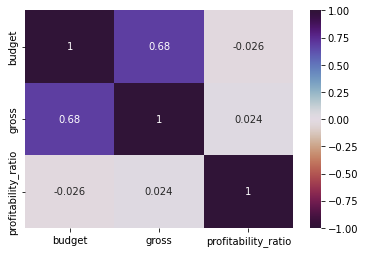

In [7]:
sns.heatmap(corr_df, vmin=-1, vmax=1, cmap='twilight_shifted_r', annot=True);

In [8]:
cov_df = df[['budget','gross','profitability_ratio']].cov()
cov_df

,budget,gross,profitability_ratio
budget,1.651097e+15,1.861042e+15,-1.345409e+08
gross,1.861042e+15,4.498548e+15,2.081329e+08
profitability_ratio,-1.345409e+08,2.081329e+08,1.635043e+04


### 2.2.2. Categorical Feature Dependency Using Chi-Square Test <a class="anchor" id="222"></a>

In [9]:
columns = ["company",  "director",  "year_released", "isprofit"]

Our data has the following columns that we can use to conduct the chi-square test on:
* Genre
* Company
* Country
* Director
* Rating
* Released
* Isprofit    
<p>
> We want to find out whether two categorical attributes are independent or dependent by using the chi-square test. We do this by getting all combinations of length two from the list above and conducting the chi-square test on each of the categorical pairs.
<br><br>
> After writing some general formulas, we will conduct the test on all 21 combinations.
</p>

#### 2.2.2.1. Chi-square Test for Each Feature <a class="anchor" id="2221"></a>

Below, we iterate over all the possible pairs of our 7 categorical features and perform a chi-square test on each pair. At the end, we summarize the results by indicating which pairs are dependent and which are not.

In [10]:
### # Get all combinations of columns array of length 2, C(7, 2) = 21 combinations
comb = it.combinations(columns, 2) 
res=[]
for i in list(comb): 
    # Contingency Table
    table = pd.crosstab(df[i[0]], df[i[1]])
    display(table)
    
    # Observed Values
    Observed_Values = table.values
    print("Observed Values")
    display(Observed_Values)
    
    # Calculate Chi-Squared test
    # Returns of scipy.state.chi2_contigency()
    # chi2: The test statistic
    # p: The p-value of the test
    # dof: Degrees of freedom
    # expected: The expected frequencies, based on the marginal sums of the table
    
    chi2_test_statistic, p, dof, expected = sp.chi2_contingency(table)
    print("chi2_test_statistic, p, dof, expected")
    display(chi2_test_statistic, p, dof, expected)
    
    # interpret test statistic
    
    # Test Statistic >= Critical Value: reject null hypotheses, dependent (Ha)
    # Test Statistic < Critical Value: fail to reject null hypotheses, independent (Ho)
    # chi2.ppf(q, df, loc=0, scale=1) inverset CDF
    
    prob = 0.95 # significant value = 1 - 0.95 = 0.05
    critical = chi2.ppf(prob, dof)
    print("critical = %.3f, chi2_test_statistic = %.3f" % (critical, chi2_test_statistic))
    
    if chi2_test_statistic >= critical:
        print("Dependent (reject H0)\n")
    else:
        print("Independent (fail to reject H0)\n")
        
    # interpret p-value
    # p-value <= alpha: reject null hypothesis, dependent (Ha)
    # p-value: > alpha: fail to reject null hypothesis, independent (Ho)
    alpha = 1.0 - prob
    print("significance = %.3f, p = %.3f" % (alpha, p))
    dependent_p = False
    if p <= alpha:
        print("Dependent (reject H0)")
        dependent_p = True
    else: 
        print("Independent (fail to reject H0)")
        
    res.append(list(i)+[dependent_p])

director,Barry Levinson,Clint Eastwood,Dennis Dugan,Joel Schumacher,Martin Scorsese,Michael Apted,Oliver Stone,Other,Renny Harlin,Richard Donner,...,Ridley Scott,Rob Reiner,Robert Zemeckis,Ron Howard,Spike Lee,Steven Soderbergh,Steven Spielberg,Tim Burton,Wes Craven,Woody Allen
company,,,,,,,,,,,,,,,,,,,,,
Castle Rock Entertainment,0,1,0,0,0,1,0,28,0,0,...,0,5,1,0,0,0,0,0,0,0
Columbia Pictures,0,0,5,0,0,0,0,80,0,0,...,0,0,0,2,0,0,1,0,0,0
Columbia Pictures Corporation,0,0,1,2,0,1,0,107,0,1,...,1,2,0,0,1,0,0,1,0,0
Dimension Films,0,0,0,0,0,0,0,30,0,0,...,0,0,0,0,0,0,0,0,4,0
DreamWorks,0,1,0,0,0,0,0,46,0,0,...,1,0,1,0,0,0,7,0,1,4
Fox 2000 Pictures,0,0,0,1,0,2,0,42,0,0,...,1,0,0,0,0,0,0,0,0,0
Fox Searchlight Pictures,0,0,0,0,0,0,0,34,0,0,...,0,0,0,0,1,0,0,0,0,0
Hollywood Pictures,0,0,0,0,0,0,0,30,0,0,...,1,0,0,0,0,0,0,0,0,0
Metro-Goldwyn-Mayer (MGM),0,0,0,0,0,0,0,58,0,0,...,1,0,0,1,0,0,0,0,0,0


Observed Values


array([[   0,    1,    0,    0,    0,    1,    0,   28,    0,    0,    1,
           0,    5,    1,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    5,    0,    0,    0,    0,   80,    0,    0,    0,
           0,    0,    0,    2,    0,    0,    1,    0,    0,    0],
       [   0,    0,    1,    2,    0,    1,    0,  107,    0,    1,    0,
           1,    2,    0,    0,    1,    0,    0,    1,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,   30,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    4,    0],
       [   0,    1,    0,    0,    0,    0,    0,   46,    0,    0,    0,
           1,    0,    1,    0,    0,    0,    7,    0,    1,    4],
       [   0,    0,    0,    1,    0,    2,    0,   42,    0,    0,    0,
           1,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,   34,    0,    0,    0,
           0,    0,    0,    0,    1,    0,    0,    0,    0,    0],

chi2_test_statistic, p, dof, expected


1107.497817707781

1.0617474852205582e-67

400

array([[1.25993190e-01, 2.09988649e-01, 1.15493757e-01, 1.04994325e-01,
        1.04994325e-01, 1.04994325e-01, 1.46992054e-01, 3.40286606e+01,
        1.25993190e-01, 1.15493757e-01, 1.36492622e-01, 1.57491487e-01,
        1.36492622e-01, 1.25993190e-01, 1.78490352e-01, 1.57491487e-01,
        1.78490352e-01, 1.99489217e-01, 1.25993190e-01, 1.25993190e-01,
        2.93984109e-01],
       [2.99659478e-01, 4.99432463e-01, 2.74687855e-01, 2.49716232e-01,
        2.49716232e-01, 2.49716232e-01, 3.49602724e-01, 8.09330306e+01,
        2.99659478e-01, 2.74687855e-01, 3.24631101e-01, 3.74574347e-01,
        3.24631101e-01, 2.99659478e-01, 4.24517594e-01, 3.74574347e-01,
        4.24517594e-01, 4.74460840e-01, 2.99659478e-01, 2.99659478e-01,
        6.99205448e-01],
       [3.98410897e-01, 6.64018161e-01, 3.65209989e-01, 3.32009081e-01,
        3.32009081e-01, 3.32009081e-01, 4.64812713e-01, 1.07604143e+02,
        3.98410897e-01, 3.65209989e-01, 4.31611805e-01, 4.98013621e-01,
        4.3161

critical = 447.632, chi2_test_statistic = 1107.498
Dependent (reject H0)

significance = 0.050, p = 0.000
Dependent (reject H0)


year_released,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
company,,,,,,,,,,,,,,,,,,,,,
Castle Rock Entertainment,0,0,0,1,1,1,2,1,2,2,...,0,0,1,0,0,0,0,0,0,0
Columbia Pictures,0,1,1,0,0,0,0,0,0,1,...,10,10,7,9,8,8,4,5,4,0
Columbia Pictures Corporation,3,3,3,5,2,5,6,9,2,4,...,0,1,0,0,0,0,0,0,0,0
Dimension Films,0,0,0,0,0,0,0,0,0,0,...,1,0,2,2,1,1,0,0,0,0
DreamWorks,0,0,0,0,0,0,0,0,0,0,...,5,4,2,4,3,1,1,1,0,0
Fox 2000 Pictures,0,0,0,0,0,0,0,0,0,0,...,2,3,4,4,3,2,1,3,1,0
Fox Searchlight Pictures,0,0,0,0,0,0,0,0,0,0,...,3,1,2,1,2,2,1,0,1,0
Hollywood Pictures,0,0,0,0,1,2,3,3,2,6,...,0,0,0,0,0,0,0,0,0,0
Metro-Goldwyn-Mayer (MGM),1,0,5,0,1,1,1,4,3,2,...,4,1,1,0,0,1,0,1,0,0


Observed Values


array([[ 0,  0,  0,  1,  1,  1,  2,  1,  2,  2,  5,  3,  2,  3,  3,  2,
         2,  1,  1,  1,  0,  3,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  3,  1,  2,
         0,  0,  2,  1,  6,  4, 10, 10,  7,  9,  8,  8,  4,  5,  4,  0],
       [ 3,  3,  3,  5,  2,  5,  6,  9,  2,  4,  7,  6,  3,  7,  9,  8,
         8,  9,  4,  9,  3,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  2,  1,  1,  4,  3,
         5,  2,  1,  2,  1,  2,  1,  0,  2,  2,  1,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  3,  3,  4,  3,
         2,  4,  7,  3,  3,  6,  5,  4,  2,  4,  3,  1,  1,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  7,  1,  2,
         2,  2,  1,  1,  5,  1,  2,  3,  4,  4,  3,  2,  1,  3,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  2,  0,  2,  0,
         5,  2,  3,  1,  1,  4,  3,  1,  2,  1,  2,  2,  1

chi2_test_statistic, p, dof, expected


1048.0378039712941

1.7352783815447647e-24

620

array([[ 0.70346198,  0.71396141,  0.91345062,  0.79795687,  0.79795687,
         0.86095346,  0.85045403,  1.01844495,  1.07094211,  1.13393871,
         1.18643587,  1.32292849,  1.23893303,  1.40692395,  1.42792281,
         1.37542565,  1.49091941,  1.38592509,  1.36492622,  1.1969353 ,
         1.30192963,  1.37542565,  1.49091941,  1.27043133,  1.35442679,
         1.38592509,  1.35442679,  1.32292849,  1.30192963,  1.28093076,
         1.08144154,  0.22048808],
       [ 1.67309875,  1.69807037,  2.17253121,  1.89784336,  1.89784336,
         2.0476731 ,  2.02270148,  2.42224745,  2.54710556,  2.6969353 ,
         2.82179342,  3.14642452,  2.94665153,  3.3461975 ,  3.39614075,
         3.27128263,  3.54597049,  3.29625426,  3.24631101,  2.84676504,
         3.09648127,  3.27128263,  3.54597049,  3.0215664 ,  3.22133939,
         3.29625426,  3.22133939,  3.14642452,  3.09648127,  3.04653802,
         2.57207719,  0.52440409],
       [ 2.22446084,  2.25766175,  2.888479  ,  2.5232

critical = 679.036, chi2_test_statistic = 1048.038
Dependent (reject H0)

significance = 0.050, p = 0.000
Dependent (reject H0)


isprofit,0,1
company,,
Castle Rock Entertainment,18,19
Columbia Pictures,33,55
Columbia Pictures Corporation,58,59
Dimension Films,12,22
DreamWorks,29,32
Fox 2000 Pictures,18,28
Fox Searchlight Pictures,11,24
Hollywood Pictures,13,18
Metro-Goldwyn-Mayer (MGM),36,24


Observed Values


array([[  18,   19],
       [  33,   55],
       [  58,   59],
       [  12,   22],
       [  29,   32],
       [  18,   28],
       [  11,   24],
       [  13,   18],
       [  36,   24],
       [  21,   24],
       [  42,   77],
       [1044,  833],
       [  59,  118],
       [  10,   22],
       [  11,   20],
       [  26,   50],
       [  17,   24],
       [  53,   75],
       [  90,  118],
       [  19,   50],
       [ 105,  107]], dtype=int64)

chi2_test_statistic, p, dof, expected


108.59106965831063

3.54619926405531e-14

20

array([[ 18.111521  ,  18.888479  ],
       [ 43.07604994,  44.92395006],
       [ 57.2715664 ,  59.7284336 ],
       [ 16.6430193 ,  17.3569807 ],
       [ 29.85953462,  31.14046538],
       [ 22.51702611,  23.48297389],
       [ 17.13251986,  17.86748014],
       [ 15.17451759,  15.82548241],
       [ 29.37003405,  30.62996595],
       [ 22.02752554,  22.97247446],
       [ 58.25056754,  60.74943246],
       [918.79256527, 958.20743473],
       [ 86.64160045,  90.35839955],
       [ 15.66401816,  16.33598184],
       [ 15.17451759,  15.82548241],
       [ 37.20204313,  38.79795687],
       [ 20.06952327,  20.93047673],
       [ 62.65607264,  65.34392736],
       [101.81611805, 106.18388195],
       [ 33.77553916,  35.22446084],
       [103.77412032, 108.22587968]])

critical = 31.410, chi2_test_statistic = 108.591
Dependent (reject H0)

significance = 0.050, p = 0.000
Dependent (reject H0)


year_released,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
director,,,,,,,,,,,,,,,,,,,,,
Barry Levinson,0,1,2,0,0,1,1,0,2,0,...,1,0,0,0,0,0,0,1,0,0
Clint Eastwood,1,0,1,0,1,0,0,1,0,1,...,1,2,1,1,0,0,1,1,1,0
Dennis Dugan,0,0,0,0,1,0,0,0,0,0,...,1,0,1,2,0,1,0,0,0,0
Joel Schumacher,0,0,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Martin Scorsese,1,0,0,0,0,0,0,0,0,1,...,0,0,1,1,0,1,0,0,0,0
Michael Apted,0,1,1,0,0,0,1,0,2,0,...,0,0,1,0,1,0,0,0,0,0
Oliver Stone,0,2,0,1,1,2,0,0,1,0,...,1,0,1,0,0,0,0,0,1,0
Other,60,59,75,64,66,72,71,92,89,96,...,133,111,121,121,123,122,117,115,96,21
Renny Harlin,1,0,1,0,2,0,0,1,0,1,...,0,1,0,0,0,0,1,0,0,0


Observed Values


array([[  0,   1,   2,   0,   0,   1,   1,   0,   2,   0,   1,   0,   2,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,
          0,   0,   0,   1,   0,   0],
       [  1,   0,   1,   0,   1,   0,   0,   1,   0,   1,   0,   2,   0,
          0,   1,   0,   1,   1,   0,   1,   0,   1,   1,   2,   1,   1,
          0,   0,   1,   1,   1,   0],
       [  0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   1,   0,   0,
          1,   0,   1,   0,   0,   0,   0,   1,   1,   1,   0,   1,   2,
          0,   1,   0,   0,   0,   0],
       [  0,   0,   0,   1,   1,   0,   0,   0,   0,   1,   1,   1,   0,
          1,   0,   1,   0,   2,   0,   0,   0,   1,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0],
       [  1,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   1,
          1,   0,   0,   1,   0,   1,   0,   1,   0,   0,   0,   1,   1,
          0,   1,   0,   0,   0,   0],
       [  0,   1,   1,   0,   0,   0,   1,   0,   2,   0,   1,   0,   0,
  

chi2_test_statistic, p, dof, expected


501.57481690005443

0.9998317758048

620

array([[2.28149830e-01, 2.31555051e-01, 2.96254257e-01, 2.58796822e-01,
        2.58796822e-01, 2.79228150e-01, 2.75822928e-01, 3.30306470e-01,
        3.47332577e-01, 3.67763905e-01, 3.84790011e-01, 4.29057889e-01,
        4.01816118e-01, 4.56299659e-01, 4.63110102e-01, 4.46083995e-01,
        4.83541430e-01, 4.49489217e-01, 4.42678774e-01, 3.88195233e-01,
        4.22247446e-01, 4.46083995e-01, 4.83541430e-01, 4.12031782e-01,
        4.39273553e-01, 4.49489217e-01, 4.39273553e-01, 4.29057889e-01,
        4.22247446e-01, 4.15437003e-01, 3.50737798e-01, 7.15096481e-02],
       [3.80249716e-01, 3.85925085e-01, 4.93757094e-01, 4.31328036e-01,
        4.31328036e-01, 4.65380250e-01, 4.59704881e-01, 5.50510783e-01,
        5.78887628e-01, 6.12939841e-01, 6.41316686e-01, 7.15096481e-01,
        6.69693530e-01, 7.60499432e-01, 7.71850170e-01, 7.43473326e-01,
        8.05902384e-01, 7.49148695e-01, 7.37797957e-01, 6.46992054e-01,
        7.03745743e-01, 7.43473326e-01, 8.05902384e-01, 6.86719

critical = 679.036, chi2_test_statistic = 501.575
Independent (fail to reject H0)

significance = 0.050, p = 1.000
Independent (fail to reject H0)


isprofit,0,1
director,,
Barry Levinson,5,7
Clint Eastwood,8,12
Dennis Dugan,2,9
Joel Schumacher,4,6
Martin Scorsese,5,5
Michael Apted,4,6
Oliver Stone,6,8
Other,1598,1643
Renny Harlin,8,4


Observed Values


array([[   5,    7],
       [   8,   12],
       [   2,    9],
       [   4,    6],
       [   5,    5],
       [   4,    6],
       [   6,    8],
       [1598, 1643],
       [   8,    4],
       [   5,    6],
       [   4,    9],
       [   9,    6],
       [   6,    7],
       [   2,   10],
       [   8,    9],
       [   8,    7],
       [   7,   10],
       [   5,   14],
       [   5,    7],
       [   4,    8],
       [  22,    6]], dtype=int64)

chi2_test_statistic, p, dof, expected


30.843244050230847

0.05729419481718886

20

array([[   5.87400681,    6.12599319],
       [   9.79001135,   10.20998865],
       [   5.38450624,    5.61549376],
       [   4.89500568,    5.10499432],
       [   4.89500568,    5.10499432],
       [   4.89500568,    5.10499432],
       [   6.85300795,    7.14699205],
       [1586.47133939, 1654.52866061],
       [   5.87400681,    6.12599319],
       [   5.38450624,    5.61549376],
       [   6.36350738,    6.63649262],
       [   7.34250851,    7.65749149],
       [   6.36350738,    6.63649262],
       [   5.87400681,    6.12599319],
       [   8.32150965,    8.67849035],
       [   7.34250851,    7.65749149],
       [   8.32150965,    8.67849035],
       [   9.30051078,    9.69948922],
       [   5.87400681,    6.12599319],
       [   5.87400681,    6.12599319],
       [  13.70601589,   14.29398411]])

critical = 31.410, chi2_test_statistic = 30.843
Independent (fail to reject H0)

significance = 0.050, p = 0.057
Independent (fail to reject H0)


isprofit,0,1
year_released,,
1986,28,39
1987,24,44
1988,39,48
1989,32,44
1990,27,49
1991,37,45
1992,40,41
1993,44,53
1994,56,46


Observed Values


array([[28, 39],
       [24, 44],
       [39, 48],
       [32, 44],
       [27, 49],
       [37, 45],
       [40, 41],
       [44, 53],
       [56, 46],
       [52, 56],
       [63, 50],
       [74, 52],
       [61, 57],
       [80, 54],
       [74, 62],
       [69, 62],
       [62, 80],
       [62, 70],
       [70, 60],
       [51, 63],
       [54, 70],
       [61, 70],
       [80, 62],
       [64, 57],
       [65, 64],
       [64, 68],
       [65, 64],
       [55, 71],
       [50, 74],
       [56, 66],
       [51, 52],
       [15,  6]], dtype=int64)

chi2_test_statistic, p, dof, expected


51.72647733579357

0.011177821079823853

31

array([[32.79653802, 34.20346198],
       [33.28603859, 34.71396141],
       [42.58654938, 44.41345062],
       [37.20204313, 38.79795687],
       [37.20204313, 38.79795687],
       [40.13904654, 41.86095346],
       [39.64954597, 41.35045403],
       [47.48155505, 49.51844495],
       [49.92905789, 52.07094211],
       [52.86606129, 55.13393871],
       [55.31356413, 57.68643587],
       [61.67707151, 64.32292849],
       [57.76106697, 60.23893303],
       [65.59307605, 68.40692395],
       [66.57207719, 69.42792281],
       [64.12457435, 66.87542565],
       [69.50908059, 72.49091941],
       [64.61407491, 67.38592509],
       [63.63507378, 66.36492622],
       [55.8030647 , 58.1969353 ],
       [60.69807037, 63.30192963],
       [64.12457435, 66.87542565],
       [69.50908059, 72.49091941],
       [59.22956867, 61.77043133],
       [63.14557321, 65.85442679],
       [64.61407491, 67.38592509],
       [63.14557321, 65.85442679],
       [61.67707151, 64.32292849],
       [60.69807037,

critical = 44.985, chi2_test_statistic = 51.726
Dependent (reject H0)

significance = 0.050, p = 0.011
Dependent (reject H0)


#### 2.2.2.2. Chi-square Test - Summary <a class="anchor" id="2222"></a>

In [11]:
dependency_matrix = pd.DataFrame(res,columns=('feature1','feature2','is_dependent'))
dependency_matrix_opposite = pd.DataFrame(dependency_matrix[['feature2','feature1','is_dependent']])
dependency_matrix_opposite.columns=('feature1','feature2','is_dependent')
dependency_matrix = pd.concat([dependency_matrix,dependency_matrix_opposite]).reset_index(drop=True)
dependency_matrix = dependency_matrix.pivot(index='feature1', columns='feature2')['is_dependent'].fillna(1)
dependency_matrix

feature2,company,director,isprofit,year_released
feature1,,,,
company,1,True,True,True
director,True,1,False,False
isprofit,True,False,1,True
year_released,True,False,True,1


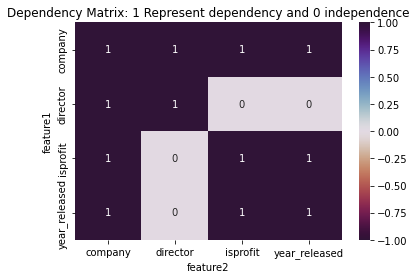

In [12]:
fig = sns.heatmap(dependency_matrix.astype(int), vmin=-1, vmax=1, cmap='twilight_shifted_r', annot=True);
fig.set_title('Dependency Matrix: 1 Represent dependency and 0 independence');

# 3. Frequent Pattern Analysis <a class="anchor" id="3"></a>

Our data has the following columns that we can perform frequent pattern analysis on:
* Genres_edited
* Spoken_languages_edited
* Keywords_edited
* Overview

<p>
> We want to find out whether there are recurring relationships in the data. For example, which genres are frequently used together to produce movies? Or which keyword combinations are frequent? After performing the analyses, we can decide, for example, which genres to produce in order to make the most profit.
<br><br>
> After writing some general functions, we will perform the analyses one by one.
</p>

## 3.1. Genres <a class="anchor" id="31"></a>

In [13]:
df.genres_edited.value_counts()

AttributeError: 'DataFrame' object has no attribute 'genres_edited'

In [ ]:
df['genres_list'] = df.genres_edited.str.split(', ')
df['genres_list'] = df.genres_list.apply(lambda x: np.array(sorted(x)))

In [ ]:
te = TransactionEncoder()
te_ary = te.fit(np.array(df.genres_list)).transform(np.array(df.genres_list))

In [ ]:
genres_encoded = pd.DataFrame(te_ary,columns=te.columns_)
genres_encoded.head()

In [ ]:
frequent_itemsets_genres = apriori(genres_encoded, min_support=0.05, use_colnames=True)\
                           .sort_values('support',ascending=False)
frequent_itemsets_genres['length'] = frequent_itemsets_genres.itemsets.apply(lambda x: len(x))

In [ ]:
frequent_itemsets_genres[(frequent_itemsets_genres.length==2)&
                         (frequent_itemsets_genres.support>=0.1)]

In [ ]:
frequent_itemsets_genres[(frequent_itemsets_genres.length==3)&
                         (frequent_itemsets_genres.support>=0.05)]

In [ ]:
rules = association_rules(frequent_itemsets_genres, metric='confidence', min_threshold=0.0)
rules.sort_values('confidence',ascending=False).head()

In [ ]:
rules['antecedents_len'] = rules.antecedents.apply(lambda x: len(x))

In [33]:
rules[
    (rules.antecedents_len >= 2) &
    (rules.confidence      >= .3) &
    (rules.lift            >= 1) &
    (rules.leverage        >= 0.01) &
    (rules.conviction      >= 1)
]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_len
28,"(Comedy, Drama)",(Romance),0.140182,0.185868,0.058173,0.414980,2.232654,0.032117,1.391630,2
38,"(Crime, Drama)",(Thriller),0.088820,0.274972,0.053632,0.603834,2.195986,0.029209,1.830112,2
40,"(Drama, Thriller)",(Crime),0.117764,0.165437,0.053632,0.455422,2.752841,0.034150,1.532494,2


## 3.2. Spoken Languages <a class="anchor" id="32"></a>

In [34]:
df.spoken_languages_edited.value_counts()

en                2523
en, es             120
en, fr              87
en, de              43
en, it              41
                  ... 
cs, en, hi           1
de, en, ru           1
bs, hr, en, sr       1
en, de, fr           1
en, fr, de, el       1
Name: spoken_languages_edited, Length: 353, dtype: int64

In [35]:
def trysort(x):
    try: return sorted(x)
    except: return []

In [36]:
df['spoken_languages_list'] = df.spoken_languages_edited.str.split(', ')
df['spoken_languages_list'] = df.spoken_languages_list.apply(trysort)

In [37]:
te = TransactionEncoder()
te_ary = te.fit(np.array(df.spoken_languages_list)).transform(np.array(df.spoken_languages_list))

In [38]:
spoken_languages_encoded = pd.DataFrame(te_ary,columns=te.columns_)
spoken_languages_encoded.head()

,0,af,ar,bg,bn,bo,br,bs,cn,cs,...,tl,to,tr,uk,ur,vi,xh,yi,zh,zu
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [39]:
frequent_itemsets_spoken_languages = apriori(spoken_languages_encoded, min_support=0.05, use_colnames=True)\
                           .sort_values('support',ascending=False)
frequent_itemsets_spoken_languages['length'] = frequent_itemsets_spoken_languages.itemsets.apply(lambda x: len(x))

In [40]:
frequent_itemsets_spoken_languages[
                         (frequent_itemsets_spoken_languages.support>=0.05)]

,support,itemsets,length
0,0.989217,(en),1
2,0.077185,(fr),1
1,0.076617,(es),1
3,0.075482,"(es, en)",2
4,0.075482,"(en, fr)",2


In [41]:
frequent_itemsets_spoken_languages[(frequent_itemsets_spoken_languages.length==3)&
                         (frequent_itemsets_spoken_languages.support>=0.05)]

,support,itemsets,length


In [42]:
rules = association_rules(frequent_itemsets_spoken_languages, metric='confidence', min_threshold=0.05)
rules.sort_values('confidence',ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(es),(en),0.076617,0.989217,0.075482,0.985185,0.995924,-0.000309,0.727866
3,(fr),(en),0.077185,0.989217,0.075482,0.977941,0.988601,-0.000870,0.488838
1,(en),(es),0.989217,0.076617,0.075482,0.076305,0.995924,-0.000309,0.999662
2,(en),(fr),0.989217,0.077185,0.075482,0.076305,0.988601,-0.000870,0.999048


In [43]:
rules['antecedents_len'] = rules.antecedents.apply(lambda x: len(x))

In [44]:
rules[
    (rules.antecedents_len >= 1) &
    (rules.confidence      >= .3) &
    (rules.lift            >= 0.75) &
    (rules.conviction      >= 0.5)
]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_len
0,(es),(en),0.076617,0.989217,0.075482,0.985185,0.995924,-0.000309,0.727866,1


## 3.3. Keywords <a class="anchor" id="33"></a>

In [45]:
df.keywords_edited.value_counts()

independent film                                                                                                                                                                             21
woman director                                                                                                                                                                               11
0                                                                                                                                                                                             9
sport                                                                                                                                                                                         9
duringcreditsstinger                                                                                                                                                                          8
                                        

In [46]:
def trysort(x):
    try: return sorted(x)
    except: return []

In [47]:
df['keywords_list'] = df.keywords_edited.str.split(', ')
df['keywords_list'] = df.keywords_list.apply(trysort)

In [48]:
te = TransactionEncoder()
te_ary = te.fit(np.array(df.keywords_list)).transform(np.array(df.keywords_list))

In [49]:
keywords_encoded = pd.DataFrame(te_ary,columns=te.columns_)
keywords_encoded.head()

,0,15th century,16th century,17th century,18th century,1910s,1920s,1930s,1940s,1950s,...,,armwrestling,epileptic seizure,flipping coin,north carolinam,nosferatu,Øverste hylde,卧底肥妈,绝地奶霸,超级妈妈
0,False,False,False,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [50]:
frequent_itemsets_keywords = apriori(keywords_encoded, min_support=0.05, use_colnames=True)\
                           .sort_values('support',ascending=False)
frequent_itemsets_keywords['length'] = frequent_itemsets_keywords.itemsets.apply(lambda x: len(x))

In [51]:
frequent_itemsets_keywords[
                         (frequent_itemsets_keywords.support>=0.05)]

,support,itemsets,length
0,0.068104,(duringcreditsstinger),1
1,0.063564,(independent film),1
2,0.061010,(woman director),1


In [52]:
rules = association_rules(frequent_itemsets_keywords, metric='confidence', min_threshold=0.05)
rules.sort_values('confidence',ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


In [53]:
rules['antecedents_len'] = rules.antecedents.apply(lambda x: len(x))

In [54]:
rules[
    (rules.antecedents_len >= 1) &
    (rules.confidence      >= .3) &
    (rules.lift            >= 0.75) &
    # (rules.leverage        >= 0.01) &
    (rules.conviction      >= 0.5)
]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_len


## 3.4. Overview <a class="anchor" id="34"></a>

In [55]:
df.overview.value_counts()

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      9
An affable underachiever finds out he's fathered 533 children through anonymous donations to a fertility clinic 20 years ago. Now he must decide whether or not to come forward when 142 of them file a lawsuit to reveal his identity.                                                                                                                                                        

In [56]:
def trysort(x):
    try: return sorted(x)
    except: return []

In [57]:
df['overview_list'] = df.overview.str.split(' ')
df['overview_list'] = df.overview_list.apply(trysort)

In [58]:
te = TransactionEncoder()
te_ary = te.fit(np.array(df.overview_list)).transform(np.array(df.overview_list))

In [59]:
overview_encoded = pd.DataFrame(te_ary,columns=te.columns_)
overview_encoded.head()

,,"""300""","""300,""","""300:","""88","""A","""A.J.""","""Address","""American","""Anthony",...,“Tributes”,“Walk,“adorable”,“an,“friend”,“heroes”,"“playbook,”",“runners”,“stalkers”,…
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [60]:
frequent_itemsets_overview = apriori(overview_encoded, min_support=0.05, use_colnames=True)\
                           .sort_values('support',ascending=False)
frequent_itemsets_overview['length'] = frequent_itemsets_overview.itemsets.apply(lambda x: len(x))

In [61]:
frequent_itemsets_overview[
                         (frequent_itemsets_overview.support>=0.05)]

,support,itemsets,length
54,0.842509,(the),1
8,0.831158,(a),1
59,0.755108,(to),1
13,0.722758,(and),1
164,0.701476,"(a, the)",2
...,...,...,...
4735,0.050227,"(for, in, he, the, and)",5
657,0.050227,"(a, When, with)",3
5563,0.050227,"(to, that, for, in, a, the)",6
4593,0.050227,"(of, a, the, on, who)",5


In [62]:
rules = association_rules(frequent_itemsets_overview, metric='confidence', min_threshold=0.05)
rules.sort_values('confidence',ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
97570,"(in, of, when, to)",(the),0.057321,0.842509,0.056754,0.990099,1.175180,0.008460,15.906640
124352,"(to, in, of, when, a)",(the),0.052497,0.842509,0.051930,0.989189,1.174100,0.007700,14.567963
78450,"(be, of, and)",(the),0.062145,0.842509,0.061294,0.986301,1.170672,0.008936,11.496879
90841,"(of, be, to, and)",(the),0.059024,0.842509,0.058173,0.985577,1.169812,0.008444,10.919410
97601,"(to, are, in, of, and)",(the),0.057605,0.842509,0.056754,0.985222,1.169391,0.008221,10.656924
...,...,...,...,...,...,...,...,...,...
138222,(the),"(an, to, and, he)",0.842509,0.054767,0.050227,0.059616,1.088533,0.004085,1.005156
137213,(the),"(to, in, and, a, with, his, is)",0.842509,0.052213,0.050227,0.059616,1.141777,0.006237,1.007872
138521,(the),"(a, new, of)",0.842509,0.053916,0.050227,0.059616,1.105721,0.004802,1.006061
138777,(the),"(to, that, for, in, a)",0.842509,0.052497,0.050227,0.059616,1.135605,0.005998,1.007570


In [63]:
rules['antecedents_len'] = rules.antecedents.apply(lambda x: len(x))

In [64]:
rules[
    (rules.antecedents_len >= 1) &
    (rules.confidence      >= .3) &
    (rules.lift            >= 0.75) &
    (rules.conviction      >= 0.5)
]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_len
0,(a),(the),0.831158,0.842509,0.701476,0.843974,1.001739,0.001218,1.009393,1
1,(the),(a),0.842509,0.831158,0.701476,0.832604,1.001739,0.001218,1.008637,1
2,(the),(to),0.842509,0.755108,0.655505,0.778040,1.030369,0.019320,1.103315,1
3,(to),(the),0.755108,0.842509,0.655505,0.868095,1.030369,0.019320,1.193974,1
4,(a),(to),0.831158,0.755108,0.645573,0.776716,1.028615,0.017959,1.096772,1
...,...,...,...,...,...,...,...,...,...,...
138811,"(only, the, to)",(a),0.056754,0.831158,0.050227,0.885000,1.064780,0.003056,1.468193,3
138812,"(a, only)","(the, to)",0.060159,0.655505,0.050227,0.834906,1.273683,0.010793,2.086655,2
138815,"(only, the)","(a, to)",0.062997,0.645573,0.050227,0.797297,1.235022,0.009558,1.748505,2
138816,"(only, to)","(a, the)",0.061294,0.701476,0.050227,0.819444,1.168172,0.007231,1.653366,2


# 4. Results <a class="anchor" id="4"></a>

## 4.1. Data Exploration Results - Continuous Features <a class="anchor" id="41"></a>

As we analyze three continuous features in <a href="#21">Section 2.1.</a>, namely *budget*, *gross (revenue)*, and *profitability_ratio*, the data seems clean enough to build our model on. Even though all the three features are positively skewed, we do not observe so many outliers that will disturb training the model.
<p>
Our initial hypothesis was that our three continuous features were meant to be correlated, because intiutively, the budget and gross and profitability of a movie sound correlated. That is, however, not the case, at least for profitability ratio and the others.
</p>
<p>
    Nonetheless, we can conclude that budget and gross are correlated. Although this information does not help us predicting the profitability ratio, we understand how independent the profitability ratio is and take it into account when we build our Machine Learning models.</p>

## 4.2. Data Exploration Results - Categorical Features <a class="anchor" id="42"></a>

<p>After analyzing our categorical features in <a href="#22">Section 2.2.</a>, we see somewhat imbalance in our 6 features. Although we have to take the imbalance problem while modeling, the one feature, *isprofit*, turns out to be very balanced. Since the *isprofit* feature is our <b>target feature</b>, we will choose a metric that objectively evaluates model performance in our classification problem.</p>

<p>After calculating the imbalances, we performed chi-square tests for each pair possible out of our 7 categorical features. In results of chi-square test (shared in <a href="#2222">Section 2.2.2.2.</a>), we observe there are quite enough couple of features that are dependent and independent. For example, *company* and *country* are correlated as we initially expected, because most of the movies in our data is made in the US.

## 4.2. Frequent Pattern Analysis Results <a class="anchor" id="43"></a>

<p>Our data included a set of features that we could perform frequent pattern analysis on, which we used for building association rules in <a href="#3"> Section 3</a>.</p>
<p>Since our dataset is not a kind of transactional data, these rules are not meant to be used for modeling. However, we still wanted to conduct this analysis in order to turn the learnings from our lectures into practice.</p>
<p>For feature *genres* (<a href="#31#">Section 3.1.</a>), we built the following association rules, after setting thresholds for confidence, leverage, conviction, and lift:
    <ul>
        <li>(Family) => (Comedy)</li>
        <li>(Romance) => (Drama)</li>
        <li>(Mystery) => (Thriller)</li>
        <li>(Crime, Drama) => (Thriller)</li>
    </ul>
When we think about those rules, they actually makes sense! For example, most of the family movies have comedy inside as well.
</p>
<p>
    For the other three features, *spoken_languages*, *keywords*, and *overview*, we cannot build such strong rules as we did in *genres*. The only rule we find strong is (es) => (en) in spoken languages. For keywords, the data is not clean enough and/or the keywords specified by different individuals so we cannot find a good association rule.
    Lastly, the *overview* feature consists of plain English sentences, therefore, although we find so many (~7 thousand) strong association rules, they are meaningless. All the strong rules in *overview* are the prefixes and conjunctions, like "a", "an", "the", "and", etc.
</p>